In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision.io import read_image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import timm
import kornia
import numpy as np
from tqdm import tqdm
import os
import json

/home/arkplus/anaconda3/envs/hrnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# imagenet 평균, 표준편차
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
# SIGMA
SIGMA = 1.5

In [3]:
# 모델
class GaugeHRNet(nn.Module):
    def __init__(self, num_keypoints=4, pretrained=True, stride_idx=1):
        super(GaugeHRNet, self).__init__()
        self.backbone = timm.create_model(
            "hrnet_w32",
            pretrained=pretrained,
            features_only=True
        )
        self.stride_idx = stride_idx
        # Stride 4 (64x64) 특징맵 채널 수 가져오기
        in_channels = self.backbone.feature_info.channels()[self.stride_idx]

        self.final_layer = nn.Conv2d(in_channels, num_keypoints, kernel_size=1)

    def forward(self, x):
        # 특징맵 리스트 추출
        x = self.backbone(x)[self.stride_idx]
        # Stride 4 (64x64)
        x = self.final_layer(x)
        return x


In [4]:
# 데이터셋
class GaugeDataset(Dataset):
    def __init__(self, root_dir, ann_file, input_size=(256, 256), is_train=True):
        self.root_dir = root_dir
        with open(ann_file, "r") as f:
            self.coco = json.load(f)
        self.image_map = {img["id"]: img for img in self.coco["images"]}
        self.annotaions = self.coco["annotations"]
        self.input_size = input_size
        self.is_train = is_train

        # 정규화
        self.normalize = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

        # 증강
        self.augment = T.Compose([
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        ]) if is_train else nn.Identity()
        

    def __len__(self):
        return len(self.annotaions)

    def __getitem__(self, index):
        annotaion = self.annotaions[index]
        image_info = self.image_map[annotaion["image_id"]]
        image_path = os.path.join(self.root_dir, image_info["file_name"])

        # Tensor C H W, 리사이즈, 0~255
        image = read_image(image_path)
        image = F.resize(image, self.input_size)
        image = image.float() / 255.0

        # 증강
        image = self.augment(image)
        # 정규화
        image = self.normalize(image)
        
        # 좌표 스케일링
        # 원본 이미지 크기 정보 가져오기
        w = image_info['width']
        h = image_info['height']

        scale_x = self.input_size[1] / w
        scale_y = self.input_size[0] / h

        keypoints = torch.tensor(annotaion["keypoints"]).view(-1, 3).float()
        keypoints[:, 0] *= scale_x
        keypoints[:, 1] *= scale_y

        return image, keypoints[:, :2]


In [5]:
# 히트맵
def generate_heatmap(keypoints, map_size, sigma=SIGMA):
    """
    [학습용] 좌표 -> 히트맵
    """
    B, N, _ = keypoints.shape
    H, W = map_size
    device = keypoints.device

    # 표준편차
    std = torch.tensor([sigma, sigma], device=device).repeat(B, N, 1)

    # Kornia 히트맵 렌더링
    heatmaps = kornia.geometry.subpix.render_gaussian2d(
        mean=keypoints,
        std=std,
        size=(H, W),
        normalized_coordinates=False # 픽셀 좌표계 사용
    )
    return heatmaps

def decode_heatmap(heatmaps):
    """
    [추론용] 히트맵 -> 좌표
    """
    # Soft Argmax
    # temperature가 높을수록 argmax에 가까워지고, 낮을수록 평균에 가까워짐
    coords = kornia.geometry.subpix.spatial_soft_argmax2d(
        input=heatmaps,
        temperature=torch.tensor(1.0, device=heatmaps.device),
        normalized_coordinates=False
    )
    return coords

In [6]:
# 히트맵 확인
def check_heatmap(dataset):
    # 데이터 하나 샘플링
    image, keypoints = dataset[0]

    # 256 -> 64 스케일
    kps = keypoints.unsqueeze(0) / 4.0

    # 히트맵 생성
    targets = generate_heatmap(kps, (64, 64), sigma=SIGMA)

    # 시각화
    plt.figure(figsize=(10, 5))

    # 정답 히트맵
    heatmap_vis = targets[0].sum(dim=0).cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.imshow(heatmap_vis, cmap='jet')
    plt.title("Target Heatmap (Ground Truth)")
    plt.colorbar()

    # 좌표 위치
    plt.subplot(1, 2, 2)
    
    # 이미지 역정규화
    inv_mean = torch.tensor([-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)]).view(3, 1, 1)
    inv_std = torch.tensor([1/s for s in IMAGENET_STD]).view(3, 1, 1)
    img_vis = image * inv_std + inv_mean
    img_vis = img_vis.permute(1, 2, 0).numpy()
    img_vis = np.clip(img_vis, 0, 1)

    plt.imshow(img_vis)

    kps_np = keypoints.numpy()

    plt.scatter(kps_np[:, 0], kps_np[:, 1], c='red', s=50)
    plt.title("")

    plt.show()

In [7]:
# 학습
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, keypoints in tqdm(dataloader, desc="학습중 "):
        images = images.to(device)
        keypoints = keypoints.to(device)

        # hrnet target 1/4
        with torch.no_grad():
            target_keypoints = keypoints / 4.0
            targets = generate_heatmap(target_keypoints, (64, 64), sigma=SIGMA)

            targets = targets * 1000.0

        # 전파
        optimizer.zero_grad()
        outputs = model(images)

        # loss
        loss = criterion(outputs, targets)

        # 역전파
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# 검증
def val(model, dataloader, criterion, device, epoch_idx=0):
    model.eval()
    total_loss = 0
    for i, (images, keypoints) in tqdm(enumerate(dataloader), "검증중 "):
        images = images.to(device)
        keypoints = keypoints.to(device)

        target_keypoints = keypoints / 4.0
        targets = generate_heatmap(target_keypoints, (64, 64), sigma=SIGMA)

        # [중요] 학습 때와 동일하게 스케일링 적용해야 Loss 비교 가능
        targets = targets * 1000.0

        # 전파
        outputs = model(images)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # 첫 번째 배치의 결과만 출력 확인
        if i == 0:
            # 좌표 복원 시에는 Scaling된 히트맵도 위치는 동일하므로 그대로 사용 가능
            pred_coords = decode_heatmap(outputs)
            pred_coords = pred_coords * 4.0
                
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [8]:
# 설정
IMG_DIR = "dataset/images"
TRAIN_ANN = "dataset/annotations/train.json"
VAL_ANN = "dataset/annotations/val.json"
SAVE_PATH = "models/hrnet/hrnet.pth"
NUM_KEYPOINTS = 4
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 100

In [9]:
print(DEVICE)

cuda


히트맵 생성 테스트를 진행합니다...


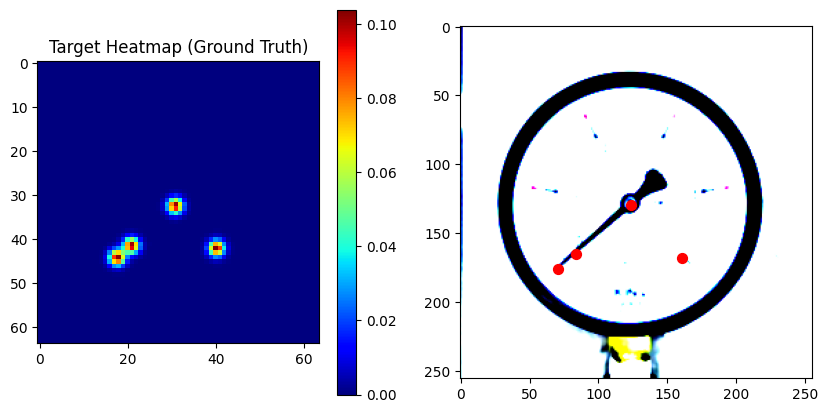

In [10]:
if os.path.exists(TRAIN_ANN) and os.path.exists(IMG_DIR):
    print("히트맵 생성 테스트를 진행합니다...")
    test_dataset = GaugeDataset(IMG_DIR, TRAIN_ANN)
    check_heatmap(test_dataset)
else:
    print("데이터셋 경로를 확인하세요. 시각화 테스트를 건너뜁니다.")

In [11]:
# 모델 초기화
model = GaugeHRNet(num_keypoints=NUM_KEYPOINTS).to(DEVICE)

Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [12]:
# 데이터셋 로드
if os.path.exists(TRAIN_ANN) and os.path.exists(VAL_ANN):
    train_dataset = GaugeDataset(IMG_DIR, TRAIN_ANN, is_train=True)
    val_dataset = GaugeDataset(IMG_DIR, VAL_ANN, is_train=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

    print(f"학습 시작 (Device: {DEVICE})")
    print("-" * 50)

    best_val_loss = float("inf")

    for epoch in range(EPOCH):
        train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
        val_loss = val(model, val_loader, criterion, DEVICE)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{EPOCH} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # 성능 개선 시 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), SAVE_PATH)
            print(f"모델 저장: {val_loss:.6f}")

        print("-" * 50)
    print("학습 완료 및 모델 저장됨.")

else:
    print("데이터셋 파일이 없습니다. 경로를 확인해주세요.")

    # dummy tets
    print("\nKornia 기능 테스트")
    dummy_out = torch.randn(1, 2, 64, 64).to(DEVICE)
    coords = decode_heatmap(dummy_out)
    print(f"Soft-Argmax 결과): {coords[0,0].tolist()}")

학습 시작 (Device: cuda)
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:03<00:00,  2.49it/s]
검증중 : 2it [00:00,  5.41it/s]


Epoch 1/100 | Train Loss: 12.692936 | Val Loss: 11.788078
모델 저장: 11.788078
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.75it/s]


Epoch 2/100 | Train Loss: 11.978388 | Val Loss: 11.279339
모델 저장: 11.279339
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 3/100 | Train Loss: 11.327458 | Val Loss: 11.000947
모델 저장: 11.000947
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 4/100 | Train Loss: 10.753444 | Val Loss: 10.681609
모델 저장: 10.681609
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 5/100 | Train Loss: 10.180811 | Val Loss: 9.611761
모델 저장: 9.611761
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 6/100 | Train Loss: 9.626275 | Val Loss: 9.908020
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 7/100 | Train Loss: 9.104702 | Val Loss: 9.346761
모델 저장: 9.346761
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 8/100 | Train Loss: 8.614643 | Val Loss: 8.784091
모델 저장: 8.784091
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 9/100 | Train Loss: 8.113444 | Val Loss: 8.587840
모델 저장: 8.587840
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 10/100 | Train Loss: 7.630747 | Val Loss: 8.625476
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 11/100 | Train Loss: 7.196208 | Val Loss: 8.204642
모델 저장: 8.204642
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.67it/s]


Epoch 12/100 | Train Loss: 6.676186 | Val Loss: 7.128082
모델 저장: 7.128082
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 13/100 | Train Loss: 6.181012 | Val Loss: 7.070610
모델 저장: 7.070610
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.69it/s]


Epoch 14/100 | Train Loss: 5.760364 | Val Loss: 6.715631
모델 저장: 6.715631
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 15/100 | Train Loss: 5.248371 | Val Loss: 5.785215
모델 저장: 5.785215
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.69it/s]


Epoch 16/100 | Train Loss: 4.793973 | Val Loss: 5.144120
모델 저장: 5.144120
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.76it/s]


Epoch 17/100 | Train Loss: 4.326936 | Val Loss: 4.916355
모델 저장: 4.916355
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 18/100 | Train Loss: 3.885747 | Val Loss: 4.150938
모델 저장: 4.150938
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
검증중 : 2it [00:00,  5.75it/s]


Epoch 19/100 | Train Loss: 3.455729 | Val Loss: 4.157185
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.76it/s]


Epoch 20/100 | Train Loss: 3.059558 | Val Loss: 3.883253
모델 저장: 3.883253
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.76it/s]


Epoch 21/100 | Train Loss: 2.689067 | Val Loss: 3.471701
모델 저장: 3.471701
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 22/100 | Train Loss: 2.342614 | Val Loss: 2.926970
모델 저장: 2.926970
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 23/100 | Train Loss: 2.044218 | Val Loss: 2.147102
모델 저장: 2.147102
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 24/100 | Train Loss: 1.756852 | Val Loss: 2.121258
모델 저장: 2.121258
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 25/100 | Train Loss: 1.485147 | Val Loss: 1.660674
모델 저장: 1.660674
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 26/100 | Train Loss: 1.249131 | Val Loss: 1.428341
모델 저장: 1.428341
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 27/100 | Train Loss: 1.048382 | Val Loss: 1.259547
모델 저장: 1.259547
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 28/100 | Train Loss: 0.860110 | Val Loss: 1.020681
모델 저장: 1.020681
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 29/100 | Train Loss: 0.699276 | Val Loss: 1.073174
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 30/100 | Train Loss: 0.563162 | Val Loss: 0.881560
모델 저장: 0.881560
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 31/100 | Train Loss: 0.448362 | Val Loss: 0.749833
모델 저장: 0.749833
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 32/100 | Train Loss: 0.355795 | Val Loss: 0.712150
모델 저장: 0.712150
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.60it/s]


Epoch 33/100 | Train Loss: 0.282574 | Val Loss: 0.636828
모델 저장: 0.636828
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
검증중 : 2it [00:00,  5.76it/s]


Epoch 34/100 | Train Loss: 0.218674 | Val Loss: 0.635744
모델 저장: 0.635744
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 35/100 | Train Loss: 0.169686 | Val Loss: 0.563962
모델 저장: 0.563962
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 36/100 | Train Loss: 0.132670 | Val Loss: 0.616629
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 37/100 | Train Loss: 0.104386 | Val Loss: 0.556713
모델 저장: 0.556713
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.69it/s]


Epoch 38/100 | Train Loss: 0.083562 | Val Loss: 0.552532
모델 저장: 0.552532
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 39/100 | Train Loss: 0.070443 | Val Loss: 0.575329
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 40/100 | Train Loss: 0.061082 | Val Loss: 0.613845
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.69it/s]


Epoch 41/100 | Train Loss: 0.050574 | Val Loss: 0.639817
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 42/100 | Train Loss: 0.043207 | Val Loss: 0.627544
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.68it/s]


Epoch 43/100 | Train Loss: 0.042728 | Val Loss: 0.618719
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 44/100 | Train Loss: 0.052279 | Val Loss: 0.786097
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 45/100 | Train Loss: 0.050995 | Val Loss: 0.714624
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 46/100 | Train Loss: 0.042898 | Val Loss: 0.829485
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.63it/s]


Epoch 47/100 | Train Loss: 0.036381 | Val Loss: 0.849972
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
검증중 : 2it [00:00,  5.66it/s]


Epoch 48/100 | Train Loss: 0.035882 | Val Loss: 0.592952
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.66it/s]


Epoch 49/100 | Train Loss: 0.033986 | Val Loss: 0.696244
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
검증중 : 2it [00:00,  5.66it/s]


Epoch 50/100 | Train Loss: 0.036394 | Val Loss: 0.753774
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.66it/s]


Epoch 51/100 | Train Loss: 0.036503 | Val Loss: 0.958474
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.76it/s]


Epoch 52/100 | Train Loss: 0.041268 | Val Loss: 0.788305
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.65it/s]


Epoch 53/100 | Train Loss: 0.027131 | Val Loss: 0.741872
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.69it/s]


Epoch 54/100 | Train Loss: 0.026332 | Val Loss: 0.691541
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.75it/s]


Epoch 55/100 | Train Loss: 0.022574 | Val Loss: 0.667955
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 56/100 | Train Loss: 0.021439 | Val Loss: 0.655376
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
검증중 : 2it [00:00,  5.69it/s]


Epoch 57/100 | Train Loss: 0.022044 | Val Loss: 0.678899
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
검증중 : 2it [00:00,  5.63it/s]


Epoch 58/100 | Train Loss: 0.019753 | Val Loss: 0.679992
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
검증중 : 2it [00:00,  5.68it/s]


Epoch 59/100 | Train Loss: 0.017757 | Val Loss: 0.677663
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.75it/s]


Epoch 60/100 | Train Loss: 0.015981 | Val Loss: 0.677286
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 61/100 | Train Loss: 0.015107 | Val Loss: 0.673329
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 62/100 | Train Loss: 0.015037 | Val Loss: 0.679944
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 63/100 | Train Loss: 0.014259 | Val Loss: 0.676819
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 64/100 | Train Loss: 0.013115 | Val Loss: 0.664010
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 65/100 | Train Loss: 0.013487 | Val Loss: 0.662284
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 66/100 | Train Loss: 0.012958 | Val Loss: 0.655966
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.70it/s]


Epoch 67/100 | Train Loss: 0.012484 | Val Loss: 0.636603
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.68it/s]


Epoch 68/100 | Train Loss: 0.012959 | Val Loss: 0.648856
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.73it/s]


Epoch 69/100 | Train Loss: 0.011993 | Val Loss: 0.653928
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 70/100 | Train Loss: 0.011752 | Val Loss: 0.645322
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.69it/s]


Epoch 71/100 | Train Loss: 0.011608 | Val Loss: 0.639417
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.65it/s]


Epoch 72/100 | Train Loss: 0.011271 | Val Loss: 0.635421
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.60it/s]


Epoch 73/100 | Train Loss: 0.011343 | Val Loss: 0.641235
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.78it/s]


Epoch 74/100 | Train Loss: 0.011331 | Val Loss: 0.653982
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 75/100 | Train Loss: 0.010859 | Val Loss: 0.654549
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 76/100 | Train Loss: 0.010799 | Val Loss: 0.664939
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
검증중 : 2it [00:00,  5.66it/s]


Epoch 77/100 | Train Loss: 0.011022 | Val Loss: 0.652298
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
검증중 : 2it [00:00,  5.75it/s]


Epoch 78/100 | Train Loss: 0.010959 | Val Loss: 0.642859
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.67it/s]


Epoch 79/100 | Train Loss: 0.010463 | Val Loss: 0.655363
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.79it/s]


Epoch 80/100 | Train Loss: 0.010534 | Val Loss: 0.666661
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.77it/s]


Epoch 81/100 | Train Loss: 0.010306 | Val Loss: 0.651331
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.82it/s]


Epoch 82/100 | Train Loss: 0.010404 | Val Loss: 0.642263
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.68it/s]


Epoch 83/100 | Train Loss: 0.010674 | Val Loss: 0.633191
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 84/100 | Train Loss: 0.010373 | Val Loss: 0.643660
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.76it/s]


Epoch 85/100 | Train Loss: 0.010129 | Val Loss: 0.649718
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 86/100 | Train Loss: 0.010181 | Val Loss: 0.653652
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.79it/s]


Epoch 87/100 | Train Loss: 0.010181 | Val Loss: 0.661309
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
검증중 : 2it [00:00,  5.78it/s]


Epoch 88/100 | Train Loss: 0.009965 | Val Loss: 0.660894
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 89/100 | Train Loss: 0.010237 | Val Loss: 0.651790
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.78it/s]


Epoch 90/100 | Train Loss: 0.009803 | Val Loss: 0.648428
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
검증중 : 2it [00:00,  5.78it/s]


Epoch 91/100 | Train Loss: 0.009791 | Val Loss: 0.637540
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 92/100 | Train Loss: 0.010099 | Val Loss: 0.649349
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.79it/s]


Epoch 93/100 | Train Loss: 0.009970 | Val Loss: 0.651505
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
검증중 : 2it [00:00,  5.71it/s]


Epoch 94/100 | Train Loss: 0.009700 | Val Loss: 0.651996
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.57it/s]


Epoch 95/100 | Train Loss: 0.010190 | Val Loss: 0.653072
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
검증중 : 2it [00:00,  5.76it/s]


Epoch 96/100 | Train Loss: 0.009997 | Val Loss: 0.660012
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.72it/s]


Epoch 97/100 | Train Loss: 0.009705 | Val Loss: 0.652971
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 98/100 | Train Loss: 0.009885 | Val Loss: 0.647159
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]


Epoch 99/100 | Train Loss: 0.009914 | Val Loss: 0.670848
--------------------------------------------------


학습중 : 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
검증중 : 2it [00:00,  5.74it/s]

Epoch 100/100 | Train Loss: 0.009642 | Val Loss: 0.657451
--------------------------------------------------
학습 완료 및 모델 저장됨.
